In [1]:
#!/usr/bin/env python
# coding: utf-8

import os, sys
import logging

import numpy as np
import h5netcdf

import xarray as xr
import xarray.ufuncs as xu
import xrft
import pandas as pd
from scipy.signal import convolve2d, detrend

from matplotlib import pyplot as plt

import cartopy.crs as ccrs
import cartopy

plt.rc("figure", figsize=(12,10))
plt.rc("font", size=14)

from dask.distributed import Client, LocalCluster
#
# Initialisation d'un cluster de 32 coeurs
cluster = LocalCluster(processes=False, n_workers=1, threads_per_worker=4, silence_logs='error')
client = Client(cluster)
client

/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33799 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://137.129.155.67:33799/status,
Dashboard: http://137.129.155.67:33799/status,Workers: 1
Total threads: 4,Total memory: 78.61 GiB
Status: running,Using processes: False
Comm: inproc://137.129.155.67/63532/1,Workers: 1
Dashboard: http://137.129.155.67:33799/status,Total threads: 4
Started: Just now,Total memory: 78.61 GiB
Comm: inproc://137.129.155.67/63532/4,Total threads: 4
Dashboard: http://137.129.155.67:42299/status,Memory: 78.61 GiB
Nanny: None,


In [2]:
def resolveWavesHayashi( varfft: xr.DataArray):  
    """This is a direct translation from the NCL routine to python/xarray.
    input:
        varfft : expected to have rightmost dimensions of freq_lon and frequency.
        varfft : expected to be an xarray DataArray with coordinate variables.
        nDayWin : integer that is the length of the segments in days.
        spd : the sampling frequency in `timesteps` per day (I think).
    returns:
        a DataArray that is reordered to have correct westward & eastward propagation.
    
    """
    #-------------------------------------------------------------
    # Special reordering to resolve the Progressive and Retrogressive waves 
    # Reference: Hayashi, Y. 
    #    A Generalized Method of Resolving Disturbances into 
    #    Progressive and Retrogressive Waves by Space and  
    #    Fourier and TimeCross Spectral Analysis
    #    J. Meteor. Soc. Japan, 1971, 49: 125-128.
    #-------------------------------------------------------------

    # in NCL varfft is dimensioned (2,mlon,nSampWin), but the first dim doesn't matter b/c python supports complex numbers.
    #
    # Create array PEE(NL+1,NT+1) which contains the (real) power spectrum.
    # all the following assume indexing starting with 0
    # In this array (PEE), the negative freq_lons will be from pn=0 to NL/2-1 (left).
    # The positive freq_lons will be for pn=NL/2+1 to NL (right).
    # Negative frequencies will be from pt=0 to NT/2-1 (left).
    # Positive frequencies will be from pt=NT/2+1 to NT  (right).
    # Information about zonal mean will be for pn=NL/2 (middle).
    # Information about time mean will be for pt=NT/2 (middle).
    # Information about the Nyquist Frequency is at pt=0 and pt=NT
    #

    # In PEE, define the 
    # WESTWARD waves to be either 
    #          positive frequency and negative freq_lon 
    #          OR 
    #          negative freq and positive freq_lon.
    # EASTWARD waves are either positive freq and positive freq_lon 
    #          OR negative freq and negative freq_lon.

    # Note that frequencies are returned from fftpack are ordered like so
    #    input_time_pos [ 0    1   2    3     4      5    6   7  ]
    #    ouput_fft_coef [mean 1/7 2/7  3/7 nyquist -3/7 -2/7 -1/7]  
    #                    mean,pos freq to nyq,neg freq hi to lo
    #
    # Rearrange the coef array to give you power array of freq and wave number east/west
    # Note east/west wave number *NOT* eq to fft freq_lon see Hayashi '71 
    # Hence, NCL's 'cfftf_frq_reorder' can *not* be used. 
    # BPM: This goes for np.fft.fftshift
    #
    # For ffts that return the coefficients as described above, here is the algorithm
    # coeff array varfft(2,n,t)   dimensioned (2,0:numlon-1,0:numtim-1)
    # new space/time pee(2,pn,pt) dimensioned (2,0:numlon  ,0:numtim  ) 
    #
    # NOTE: one larger in both freq/space dims
    # the initial index of 2 is for the real (indx 0) and imag (indx 1) parts of the array
    #
    #
    #    if  |  0 <= pn <= numlon/2-1    then    | numlon/2 <= n <= 1
    #        |  0 <= pt < numtim/2-1             | numtim/2 <= t <= numtim-1
    #
    #    if  |  0         <= pn <= numlon/2-1    then    | numlon/2 <= n <= 1
    #        |  numtime/2 <= pt <= numtim                | 0        <= t <= numtim/2
    #
    #    if  |  numlon/2  <= pn <= numlon    then    | 0  <= n <= numlon/2
    #        |  0         <= pt <= numtim/2          | numtim/2 <= t <= 0
    #
    #    if  |  numlon/2   <= pn <= numlon    then    | 0        <= n <= numlon/2
    #        |  numtim/2+1 <= pt <= numtim            | numtim-1 <= t <= numtim/2

    # local variables : dimvf, numlon, N, varspacetime, pee, wave, freq

    # bpm: if varfft is a numpy array, then we need to know which dim is longitude
    #      if it is an xr.DataArray, then we can just use that directly. This is 
    #      reason enough to insist on a DataArray.
    #      varfft should have a last dimension of "segments" of size N; should make a convention for the name of that dimension an insist on it here.
#     logging.debug(f"[Hayashi] nDayWin: {nDayWin}, spd: {spd}")
    dimnames = varfft.dims
    dimvf  = varfft.shape
    mlon   = len(varfft['freq_lon'])
    N      = dimvf[-1]
    logging.info(f"[Hayashi] input dims is {dimnames}, {dimvf}")
    logging.info(f"[Hayashi] input coords is {varfft.coords}")
    if len(dimnames) != len(varfft.coords):
        logging.error("The size of varfft.coords is incorrect.")
        raise ValueError("STOP")

    nshape = list(dimvf)
    nshape[-2] += 1
    nshape[-1] += 1
    logging.debug(f"[Hayashi] The nshape ends up being {nshape}")
    # this is a reordering, use Ellipsis to allow arbitrary number of dimensions,
    # but we insist that the freq_lon and frequency dims are rightmost.
    # we will fill the new array in increasing order (arbitrary choice)
    logging.debug("allocate the re-ordered array")
    varspacetime = np.full(nshape, np.nan, dtype=type(varfft))
    print(np.shape(varspacetime))
    print(np.shape(varfft))

    print(mlon//2)
    # first two are the negative freq_lons (westward), second two are the positive freq_lons (eastward)
    logging.debug(f"[Hayashi] Assign values into array. Notable numbers: mlon//2={mlon//2}, N//2={N//2}")
    varspacetime[..., 0:(mlon//2), 0:N//2    ] = varfft[..., (mlon//2):0:-1, N//2:] # neg.k, pos.w
    varspacetime[..., 0:mlon//2, N//2:     ] = varfft[..., mlon//2:0:-1, 0:N//2+1]   # neg.k, 
    varspacetime[..., mlon//2:   , 0:N//2+1] = varfft[..., 0:mlon//2+1,  N//2::-1]   # assign eastward & neg.freq.
    varspacetime[..., mlon//2:   , N//2+1: ] = varfft[..., 0:mlon//2+1, -1:N//2-1:-1] # assign eastward & pos.freq.
    print(varspacetime.shape)
#     #  Create the real power spectrum pee = sqrt(real^2+imag^2)^2
#     logging.debug("calculate power")
#     pee       = (np.abs(varspacetime))**2
#     logging.debug("put into DataArray")
#     # add meta data for use upon return
#     wave      = np.arange(-mlon // 2, (mlon // 2 )+ 1, 1, dtype=int)  
#     freq      = np.linspace(-1*nDayWin*spd/2, nDayWin*spd/2, (nDayWin*spd)+1) / nDayWin

#     print(f"freq size is {freq.shape}.")
#     odims = list(dimnames)
#     odims[-2] = "freq_lon"
#     odims[-1] = "frequency"
#     ocoords = {}
#     for c in varfft.coords:
#         logging.debug(f"[hayashi] working on coordinate {c}")
#         if (c != "freq_lon") and (c != "frequency"):
#             ocoords[c] = varfft[c]
#         elif c == "freq_lon":
#             ocoords['freq_lon'] = wave
#         elif c == "frequency":
#             ocoords['frequency'] = freq
#     pee = xr.DataArray(pee, dims=odims, coords=ocoords)
    return varspacetime


In [3]:
path = "/home/durand/Documents/OLR/"

indir_data = path + 'Anomaly/'
outdir_TF = path + 'TF2D/'

indir_data = '/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/RAW_ANOMALY/OLR/'
outdir_data = '/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/FILTERED_ANOMALY/OLR/'

var_file = 'anom_OLR_brut_ERA5_3H'

addDay = 180
spd = 8

In [4]:
rlat = 0
pi    = np.pi
radius = 6.37122e06    # [m]   average radius of earth
g     = 9.80665        # [m/s] gravity at 45 deg lat used by the WMO
omega = 7.292e-05      # [1/s] earth's angular vel
ll    = 2.*pi*radius*np.cos(np.abs(rlat))
Beta  = 2.*omega*np.cos(np.abs(rlat))/radius
fillval = 1e20

In [5]:
###################################################################################
def createArray(year) :
    _ds_m1 = xr.open_mfdataset(indir_data+'*'+var_file+'*'+str(year-1)+'.nc', chunks = {'lat' : 1}, parallel=True)
    _ds_m1 = _ds_m1.isel(time = slice(addDay*spd,None))
    _ds = xr.open_mfdataset(indir_data+'*'+var_file+'*'+str(year)+'.nc', chunks = {'lat' : 1}, parallel=True)
    _ds1 = xr.open_mfdataset(indir_data+'*'+var_file+'*'+str(year+1)+'.nc', chunks = {'lat' : 1}, parallel=True)
    _ds1 = _ds1.isel(time = slice(None,addDay*spd))

    ds = xr.concat([_ds_m1,_ds,_ds1], dim='time', coords='minimal', compat='override')
    
    return ds

In [6]:
def split_hann_taper(series_length, fraction):
    """Implements `split cosine bell` taper of length series_length where only fraction of points are tapered (combined on both ends).
    
    This returns a function that tapers to zero on the ends. To taper to the mean of a series X:
    XTAPER = (X - X.mean())*series_taper + X.mean()
    """
    npts = int(np.rint(fraction * series_length))  # total size of taper
    taper = np.hanning(npts)
    series_taper = np.ones(series_length)
    series_taper[0:npts//2+1] = taper[0:npts//2+1]
    series_taper[-npts//2+1:] = taper[npts//2+1:]
    return series_taper, taper


def convolvePosNeg(arr, k, dim, boundary_index):
    """Apply convolution of (arr, k) excluding data at boundary_index in dimension dim.
    
    arr: numpy ndarray of data
    k: numpy ndarray, same dimension as arr, this should be the kernel
    dim: integer indicating the axis of arr to split
    boundary_index: integer indicating the position to split dim
    
    Split array along dim at boundary_index;
    perform convolution on each sub-array;
    reconstruct output array from the two subarrays;
    the values of output at boundary_index of dim will be same as input.
    
    `convolve2d` is `scipy.signal.convolve2d()`
    """
    # arr: numpy ndarray
    oarr = arr.copy()  # maybe not good to make a fresh copy every time?
    # first pass is [0 : boundary_index)
    slc1 = [slice(None)] * arr.ndim
    slc1[dim] = slice(None, boundary_index)
    arr1 = arr[tuple(slc1)]
    ans1 = convolve2d(arr1, k, boundary='symm', mode='same')
    # second pass is [boundary_index+1, end]
    slc2 = [slice(None)] * arr.ndim
    slc2[dim] = slice(boundary_index+1,None)
    arr2 = arr[tuple(slc2)]
    ans2 = convolve2d(arr2, k, boundary='symm', mode='same')
    # fill in the output array
    oarr[tuple(slc1)] = ans1
    oarr[tuple(slc2)] = ans2
    return oarr

In [7]:
# filenames = np.arange(2008,2009)
# datasets = []
# var = 'OLR'
def mjofilter(da, fmin=None, fmax=None, kmin=None, kmax=None) :
    """kelvin wave filter
    Arguments:
       'fmin/fmax' -- unit is cycle per day
       'kmin/kmax' -- zonal wave number
       'hmin/hmax' --equivalent depth
    """
    
    knum = da.freq_lon
    freq = da.freq_time

    # filtering ############################################################
    mask = da.copy()
    #wavenumber cut-off
    if kmin != None:
        mask = mask.where((da.freq_lon > kmin) & (da.freq_lon < kmax), drop = False)
    
    #frequency cutoff
    if fmin != None:
        mask = mask.where((da.freq_time > fmin) & (da.freq_time < fmax), drop = False)

    _varhat = mask.compute()
    _varhat['freq_lon'] = freq_lon_Save
    _varhat['freq_time'] = freq_time_Save
#     print(_varhat)
    fftdata = _varhat.values
#     fftdata = np.flip(fftdata, axis = 2)
#     fftdata = np.flip(fftdata, axis = 0)

    
#     print(fftdata)
#     fftdata = xr.DataArray(np.flip(fftdata , axis = 2),
#                            dims=("freq_time","lat","freq_lon"), 
#                            coords={"freq_time":_varhat.freq_time,
#                                    "lat":_varhat.lat,
#                                  "freq_lon":_varhat.freq_lon}
#                                  )
    
    fftdata = xr.DataArray(fftdata,
                       dims=("freq_time","lat","freq_lon"), 
                       coords={"freq_time":_varhat.freq_time,
                               "lat":_varhat.lat,
                             "freq_lon":_varhat.freq_lon}
                             )
    
    
    filterd = xrft.ifft(fftdata.fillna(0.), dim = ['freq_time','freq_lon'], 
                                  true_phase=False, true_amplitude=True) # Signal in direct space
    filterd['time'] = ds['time']
    
    return mask, filterd





# # for f in filenames:
f = 2008
ds = createArray(f)
x_wintap = ds['OLR_ano'].chunk({"time" : -1, "lat": 1})

tcwvhat = xrft.fft(x_wintap, detrend='linear',
            dim=['time','lon'], true_phase=False, true_amplitude=True)
tcwvhat

<xarray.DataArray 'rechunk-merge-b7ef09f7f1665fa95e6aff4da3c7a3ce' (freq_time: 5848, lat: 60, freq_lon: 360)>
dask.array<mul, shape=(5848, 60, 360), dtype=complex128, chunksize=(5848, 1, 360), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float32 -29.5 -28.5 -27.5 -26.5 ... 26.5 27.5 28.5 29.5
  * freq_time  (freq_time) float64 -4.63e-05 -4.628e-05 ... 4.626e-05 4.628e-05
  * freq_lon   (freq_lon) float64 -0.5 -0.4972 -0.4944 ... 0.4917 0.4944 0.4972

In [12]:

# _tcwvhat_2 = resolveWavesHayashi(tcwvhat)
_tcwvhat = tcwvhat.copy()
        
#####################################
### We save freq_lon in ° and freq_time in second, because we use wavenumber and cycle by day for filtering
freq_lon_Save = tcwvhat['freq_lon']
freq_time_Save = tcwvhat['freq_time']
#####################################
wavenumber = np.zeros(_tcwvhat.freq_lon.size)
for i in range( _tcwvhat.freq_lon.size):
    j= - int(360/2) + i
    wavenumber[i] = _tcwvhat.freq_lon[int(360/2)+j]*360 + 1
#     print(wavenumber[i])

_tcwvhat['freq_lon'] = wavenumber
_tcwvhat['freq_time'] = tcwvhat.freq_time*86400
print(1/_tcwvhat['freq_time'][int(5848//2)+2])
#########################################
# MJO Filtering
"""
MJO
waveName = "MJO"   ; kiladis et al. 2009
tMin = 30.
tMax = 96.
kMin = 0
kMax = 9  # 5 is also possible
hMin = mis
hMax = mis
"""
    
#     ds_NetCdf = ds_NetCdf.sel(time = str(f))
#     ds_NetCdf.to_netcdf(outdir_data + 'OLR_CERES_3H_' + str(f) +'.nc', unlimited_dims='time')

<xarray.DataArray 'freq_time' ()>
array(365.5)
Coordinates:
    freq_time  float64 0.002736


'\nMJO\nwaveName = "MJO"   ; kiladis et al. 2009\ntMin = 30.\ntMax = 96.\nkMin = 0\nkMax = 9  # 5 is also possible\nhMin = mis\nhMax = mis\n'

In [13]:
plt.rc("figure", figsize=(16,4))
plt.rc("font", size=14)
ccrs.PlateCarree()

map_proj = ccrs.Mercator(central_longitude=0.0, 
                         min_latitude=-30.0, 
                         max_latitude=30.0, 
                         globe=None)


_dahat_MJO, da_MJOfilter = mjofilter(_tcwvhat, fmax = -1/96, fmin = -1/30, kmax = 5, kmin = 0)
da_MJOfilter = da_MJOfilter.sel(time = '2008')

power = da_MJOfilter.real
# power = power.roll(lon = 180)
# for i in range(20) :
#     fig, axis = plt.subplots(
#         1, 1, subplot_kw={'projection': map_proj})

#     power.isel(time = i*8*4).plot.contourf(ax=axis, levels = 101,
#                         transform=ccrs.PlateCarree())

#     axis.coastlines()
#     gl = axis.gridlines(draw_labels=True)
#     gl.top_labels = False
#     gl.right_labels = False
#     plt.show()

/home/durandy/miniconda3/envs/towel/lib/python3.9/site-packages/xrft/xrft.py:556: FutureWarning: Default idft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


In [14]:
_da_MJOfilter = da_MJOfilter.real.values
_da_MJOfilter = np.roll(_da_MJOfilter, 180, axis = 2)

da_MJOfilter = xr.DataArray(_da_MJOfilter,
                       dims=("time","lat","lon"), 
                       coords={"time":da_MJOfilter.time,
                               "lat":da_MJOfilter.lat,
                             "lon":da_MJOfilter.lon}
                             )
da_MJOfilter['time'] = pd.date_range(start = '2008-01-01', end = '2009-01-01', freq = '3H', closed = 'left')

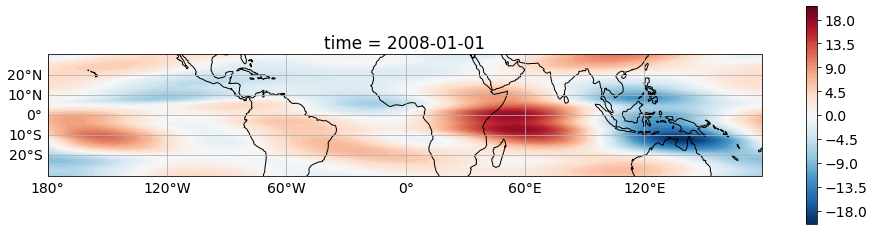

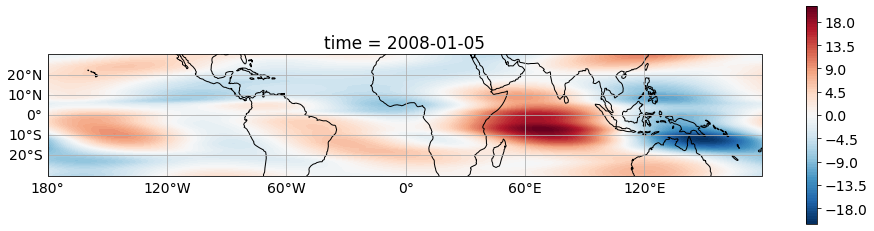

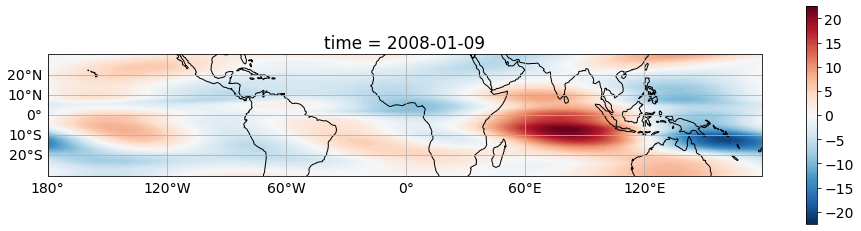

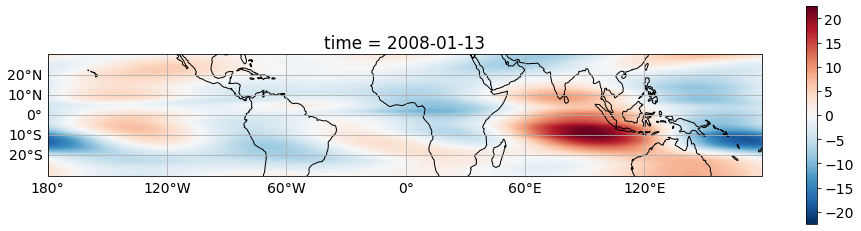

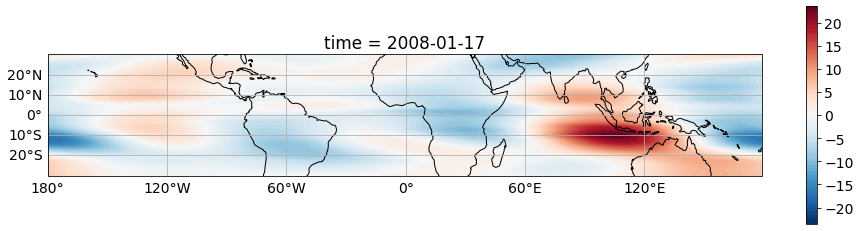

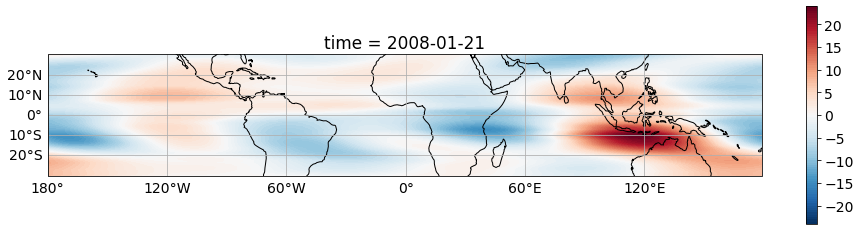

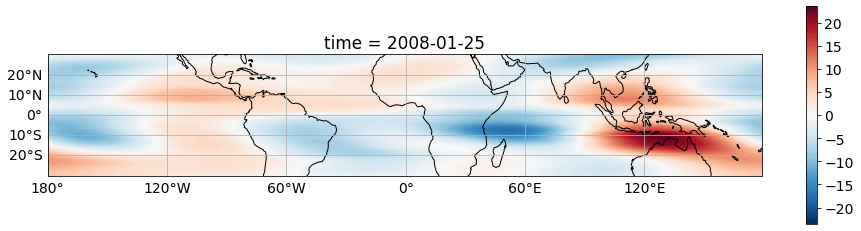

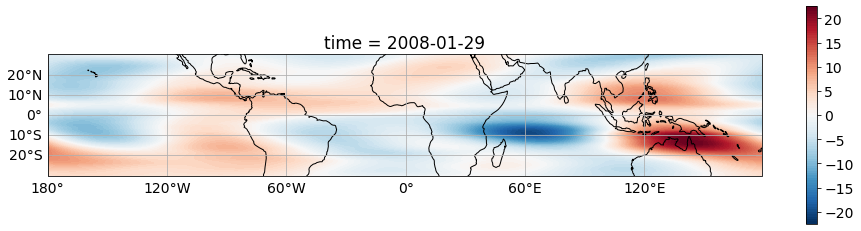

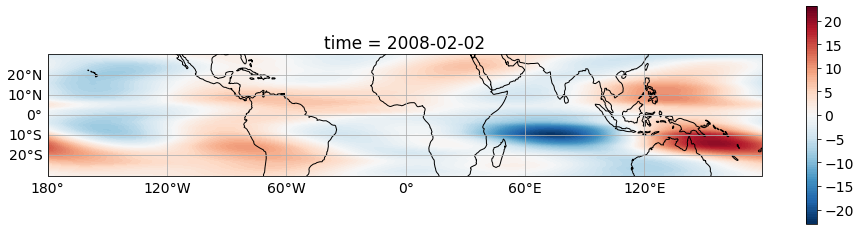

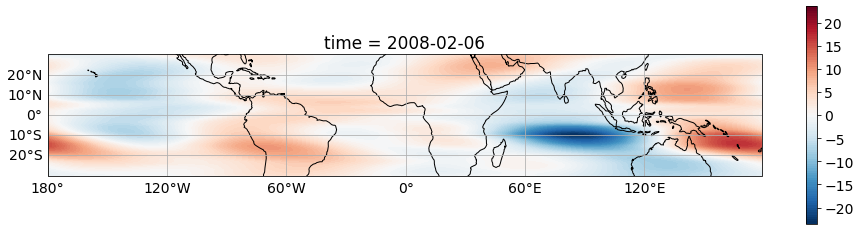

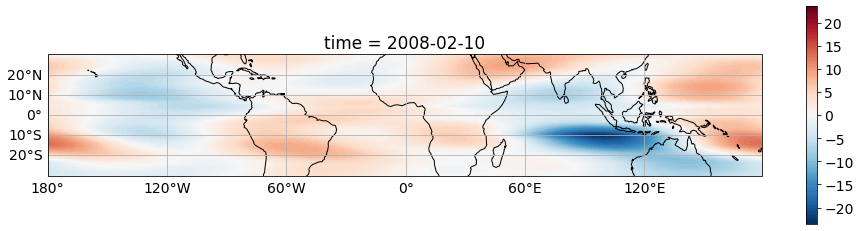

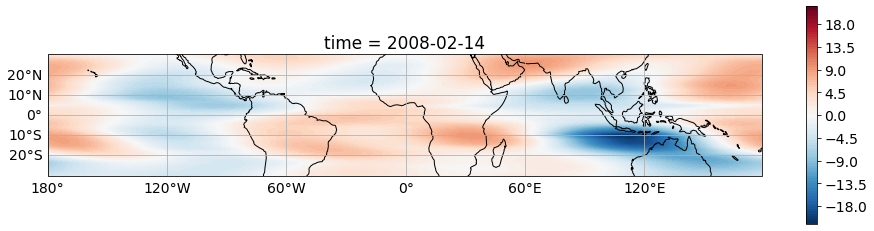

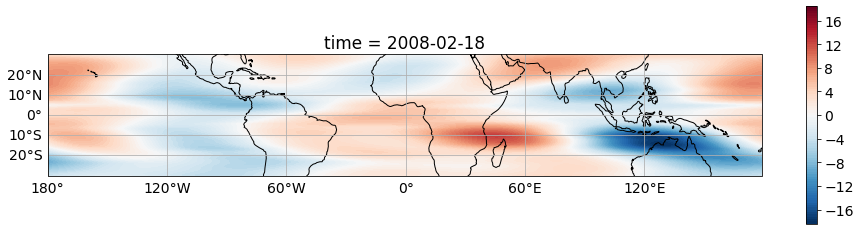

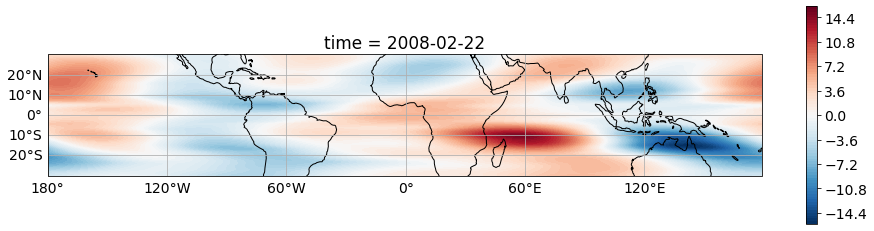

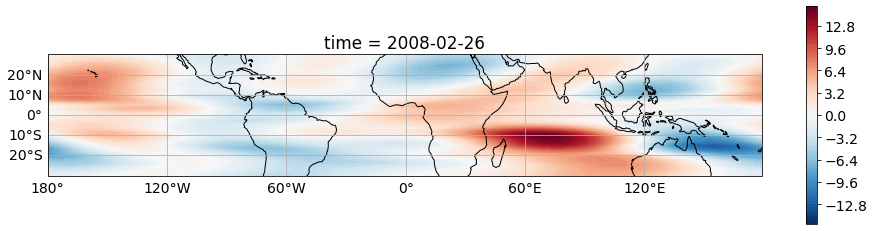

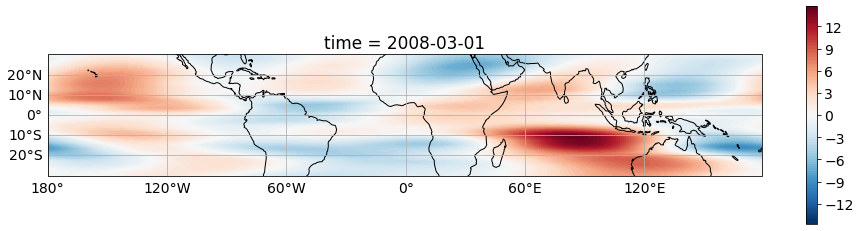

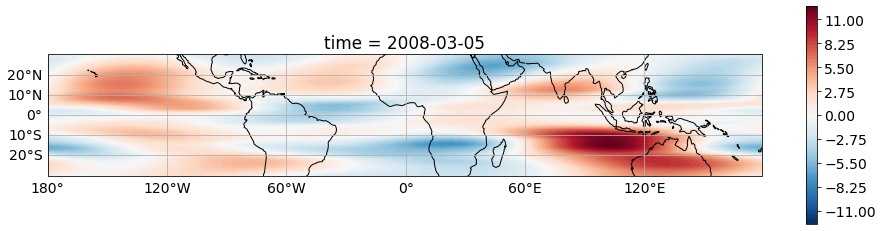

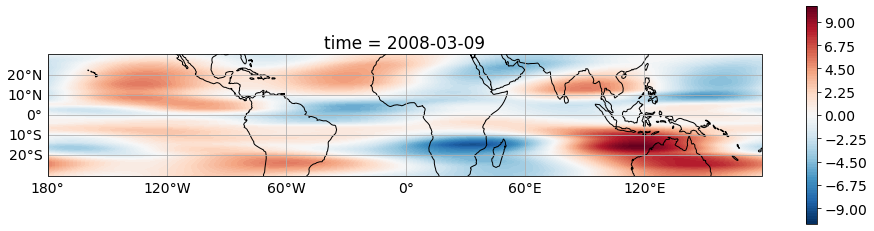

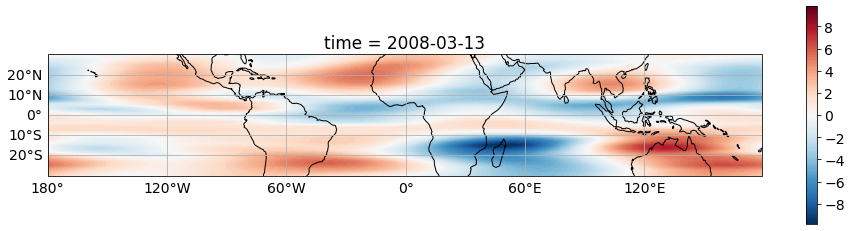

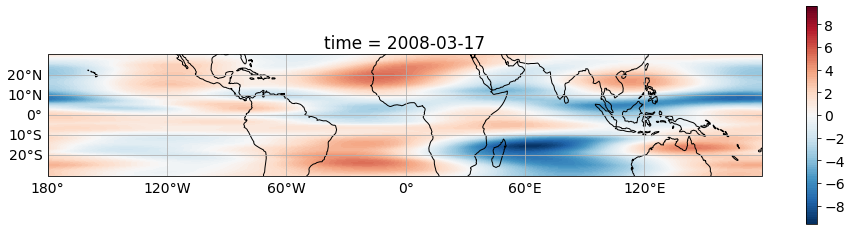

In [15]:
for i in range(20) :
    fig, axis = plt.subplots(
        1, 1, subplot_kw={'projection': map_proj})

    da_MJOfilter.isel(time = i*8*4).plot.contourf(ax=axis, levels = 101,
                        transform=ccrs.PlateCarree())

    axis.coastlines()
    gl = axis.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    plt.show()